# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


First we want to check the requirements of CLT and check for normality (using a Q-Q Plot).
The requirements of the CLT:
1. Large enough sample size (>=30)
2. Independent Samples

In [5]:
data_race = data.loc[:,['race','call']]
data_race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 2 columns):
race    4870 non-null object
call    4870 non-null float32
dtypes: float32(1), object(1)
memory usage: 95.1+ KB


1. There are 4870 observations making this data set large enough for the CLT to apply.
2. The samples are independent of each other as they represent individual observations of resumes. One resume has no knowing impact on another resume being submitted.

The data we're looking at is a discrete distribution (as opposed to continuous). In fact, it is even more restricted, we're working with binary distributed data, meaning a Bernoulli Trial seems an appropriate test setup.

There is a couple assumptions we can make using this binomial model:
- The number of r successes in n Bernoulli trials with probability p of success, is Binomially distributed.
- The Central Limit Theorem applies as long as min(np, n(1-p)) >= 5

Let's explore the data!

In [6]:
n = len(data_race)
print("Total Number of Resumes: {}".format(n))

b_resumes = data_race['race'] == 'b'
w_resumes = data_race['race'] == 'w'
print("Resumes by Race: black (b) = {} white (w) = {}".format(np.sum(b_resumes),np.sum(w_resumes)))

callbacks = data_race['call'] == 1
call_ratio = np.sum(callbacks)/len(data_race)
print("Call Ratio: {}".format(call_ratio))

Total Number of Resumes: 4870
Resumes by Race: black (b) = 2435 white (w) = 2435
Call Ratio: 0.08049281314168377


We can see that the resumes were perfectly split between white-sounding and black-sounding names. It is also important to note that the call ratio is quite low overall with slightly over 8% of all resumes receiving a call.

If the probability to receive a call for a white-sounding name and a black-sounding name is the same then we shouldn't see any significant differences between these two groups in our sample.

    H0: The difference of callback ratios between white- and black-sounding names is 0.
    H1: The difference of callback ratios between white- and black-sounding names is not 0.

In [7]:
w = data[data.race=='w']
b = data[data.race=='b']

Let's perform a Bernoulli Trial with the Bootstrap method.

In [8]:
def generate_ratio(data):
    return np.sum(data == 1) / len(data)

b_callratio = generate_ratio(b.call)
w_callratio = generate_ratio(w.call)

print("Callback Ratio for Black: {}".format(b_callratio))
print("Callback Ratio for White: {}".format(w_callratio))
   
# Define Comparison Function Difference of Ratios
def ratio_diff(data1,data2):
    ratio1 = generate_ratio(data1)
    ratio2 = generate_ratio(data2)
    return ratio1 - ratio2

b_w_diff = ratio_diff(b.call,w.call)
print("Difference between Black and White Calls for Interviews: {}".format(b_w_diff))

Callback Ratio for Black: 0.06447638603696099
Callback Ratio for White: 0.09650924024640657
Difference between Black and White Calls for Interviews: -0.032032854209445585


In [9]:
# Define a few utility functions for Q-Q plots and ECDF
def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    return x,y

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq(data):
    (x,y), (slope,intercept,r) = stats.probplot(data, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    return (x_lreg,y_lreg),(x,y)

p: 0.0
CI: [-0.01478439  0.01560575]
ME: 0.015509897330595488


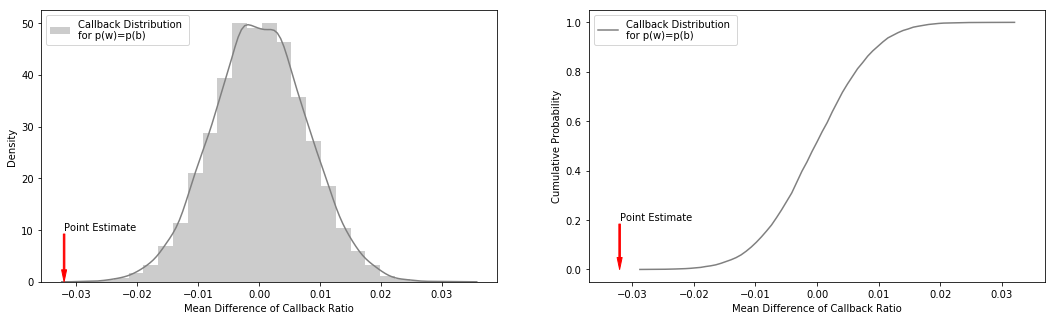

In [57]:
# Seed Random
np.random.seed(500)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

perm_replicates = draw_perm_reps(b.call,w.call,ratio_diff,10000)

p = np.sum(perm_replicates <= b_w_diff) / len(perm_replicates)
print("p: {}".format(p))

CI = np.percentile(perm_replicates,[2.5,97.5])
print("CI: {}".format(CI))

ME = CI[1] - np.mean(perm_replicates)
print("ME: {}".format(ME))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

plt.subplot(1,2,1)

_ = sns.distplot(perm_replicates,bins=25,color='gray')
_ = plt.xlabel('Mean Difference of Callback Ratio')
_ = plt.ylabel('Density')
_ = plt.legend(['Callback Distribution \nfor p(w)=p(b)'],loc='upper left')
_ = plt.annotate(s='Point Estimate',xy=(b_w_diff,0),xytext=(b_w_diff,10),
                 arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


## CI_area = perm_replicates[perm_replicates <= CI[0]]
## _ = plt.hist(CI_area)

plt.subplot(1,2,2)

x,y = ecdf(perm_replicates)
y_interp = np.interp(x,x,y)
_ = plt.plot(x,y_interp,color='gray')
_ = plt.xlim([b_w_diff - 0.005,-b_w_diff + 0.005])

_ = plt.xlabel('Mean Difference of Callback Ratio')
_ = plt.ylabel('Cumulative Probability')
_ = plt.legend(['Callback Distribution \nfor p(w)=p(b)'],loc='upper left')
_ = plt.annotate(s='Point Estimate',xy=(b_w_diff,0),xytext=(b_w_diff,0.2),
                 arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

_Interpretation:_ Using a permutation approach the Point Estimate Ratio Difference of -0.032 has a very low probability (i.e. we weren't able to generate a result as extreme as the original even once). The acceptable differences for a 95% Confidence Interval (p<0.05) are [-0.015, 0.016]. This puts the Point Estimate fairly out of a likely result if H0 was true.

_Conclusion:_ Given the results above, we can reject H0 and have gathered evidence to support H1. The data indicates that there might be a bias towards white-sounding names and a bias against black-sounding names in the job application process.

We'll validate our results using a frequentist approach.

### Proportional Z-Test 

To set this test up we'll have to find the ratio difference and compare it to the combined proportion distribution.

Formulas: 
- z=((x1-x2) - 0)/SE_x1_x2 -- Z Value (Ratio difference minus expected difference divided by combined standard deviation)
- SE = sqrt(k\*p\*(1-p)/n) -- Standard Error for the Distribution of proportions of successes for Binomial Distributions follows approximately a normal distribution (k is the number of Bernoulli draws, usually 1) 
    - [more information](https://en.wikipedia.org/wiki/Binomial_distribution) on Wikipedia see _Normal Approximation_ and search for _proportion z-test_, also additional information on [p distribution](http://onlinestatbook.com/2/sampling_distributions/samp_dist_p.html)
- SE_x1_x2=np.sqrt((SE_x1\*\*2) + (SE_x2\*\*2)) -- Sample Error for two ratio of success Binomial Distributions
- CI +- Margin of Error (ME) -- Confidence Interval
- ME = z_crit\*SE -- Margin of Error

Define the Hypotheses:
(see above)

95% Confidence Interval (CI) (alpha=0.05):
- z_crit = -1.96/1.96

In [133]:
# The ratio difference was already generated in the Bootstrap approach
print("Difference between Black and White Calls for Interviews: {}".format(b_w_diff))

Difference between Black and White Calls for Interviews: -0.032032854209445585


In [135]:
# Calculate the Standard Deviation of the ratio of callbacks for black-sounding names
# The distribution of the proportions of successes (not the distribution of successes) 
# approximately follows a normal distribution.
n_b = len(b.call)
p_b = generate_ratio(b.call)
SE_b = np.sqrt(p_b * (1-p_b)/n_b)

# Calculate the same for the ratio of callbacks for white-sounding names
n_w = len(w.call)
p_w = generate_ratio(w.call)
SE_w = np.sqrt(p_w * (1-p_w)/n_w)

# Calculate the combined Standard Error
SE_b_w=np.sqrt(SE_b**2 + SE_w**2)
print("SE: {}".format(SE_b_w))

# Calculate the Z Value
z = ((b_w_diff) - ratio_diff_h0)/SE_b_w

print("z: {}".format(z))

# Calculate the CI
z_crit = 1.96
ME = z_crit * SE_b_w
CI = [0 - ME, 0 + ME]
print("CI: {}".format(CI))

SE: 0.0077833705866767544
z: -4.11555043573
CI: [-0.015255406349886438, 0.015255406349886438]


_Interpretation:_ The z-value (-4.12) is far in the critical region <= -1.96 and can be considered unlikely to have been randomly drawn if the success proportions were equally distributed for p<0.05. The 95% Confidence Interval states that for H0 to be an acceptable Hypothesis the difference of ratios would have to be >=-0.015 and <=0.015.

_Conclusion:_ Again, we're able to reject H0 (p<0.05). This means that there is a significant difference between white- and black-sounding names in the job application process. It appears that black-sounding names have a lower rate of success to receive a call for an interview.

# 4. 

# 5.  